In [185]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import plotly.graph_objects as go

# K-mean Venue-data within 1km

In [186]:
# Import venue data within 1km of each neighborhood
venue_data = pd.read_csv('/Users/karina/GitHub/NYC_midterm_project/data/data/all_venues_data_1km.csv')
venue_data.head()

,id,accounting,amusement_park,aquarium,art_gallery,bakery,bank,bar,beauty_salon,bicycle_store,...,supermarket,synagogue,taxi_stand,tourist_attraction,train_station,transit_station,travel_agency,university,veterinary_care,zoo
0,nyu_2451_34572.1,1,0,0,0,1,2,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,nyu_2451_34572.10,0,0,0,0,1,1,0,2,0,...,1,0,0,0,0,0,0,0,0,0
2,nyu_2451_34572.100,0,0,0,0,1,0,4,1,0,...,0,0,0,0,0,0,0,0,0,0
3,nyu_2451_34572.101,0,0,0,1,2,0,4,0,0,...,0,0,0,2,0,0,0,0,0,0
4,nyu_2451_34572.102,0,0,0,0,0,2,5,0,0,...,0,1,0,0,0,0,1,0,0,0


In [187]:
# Create function to find the most common venues per neighborhood
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [188]:
# Create new dataframe for most common venues
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['id']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
venues_sorted = pd.DataFrame(columns=columns)
venues_sorted['id'] = venue_data['id']

for ind in np.arange(venue_data.shape[0]):
    venues_sorted.iloc[ind, 1:] = return_most_common_venues(venue_data.iloc[ind, :], num_top_venues)

In [189]:
venues_sorted.head()

,id,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,nyu_2451_34572.1,school,doctor,health,secondary_school,church
1,nyu_2451_34572.10,church,secondary_school,school,funeral_home,general_contractor
2,nyu_2451_34572.100,doctor,bar,health,restaurant,dentist
3,nyu_2451_34572.101,lodging,cafe,night_club,bar,restaurant
4,nyu_2451_34572.102,doctor,restaurant,bar,church,park


In [190]:
# Import neighborhood data
neighborhood_data = pd.read_csv('/Users/karina/GitHub/NYC_midterm_project/data/old_dataset.csv')
neighborhood_data = neighborhood_data.iloc[:, 1:6]
neighborhood_data.head()

,id,borough,neighborhood,longitude,latitude
0,nyu_2451_34572.1,Bronx,Wakefield,-73.847201,40.894705
1,nyu_2451_34572.2,Bronx,Co-op City,-73.829939,40.874294
2,nyu_2451_34572.3,Bronx,Eastchester,-73.827806,40.887556
3,nyu_2451_34572.4,Bronx,Fieldston,-73.905643,40.895437
4,nyu_2451_34572.5,Bronx,Riverdale,-73.912585,40.890834


In [191]:
# Drop neighborhood ID to create numerical data for k-means clustering
venue_clustering = venue_data.drop('id', axis=1)

In [192]:
# Create elbow graph function
def plot_distortion(X,max_clusters = 10):
    distortions = []
    for i in range(1, max_clusters +1):
        km = KMeans(n_clusters=i,
                    init='k-means++',
                    n_init=10,
                    random_state=0)
        km.fit(X)
        distortions.append(km.inertia_)

    plt.plot(range(1,max_clusters +1), distortions, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.show() 

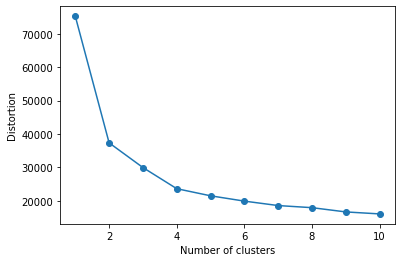

In [193]:
# Plot elbow graph
plot_distortion(venue_clustering)

In [194]:
# Cluster data points using kmeans and get labels
kclusters = 3

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(venue_clustering)

kmeans.labels_[0:10] 

array([0, 0, 2, 0, 0, 2, 0, 0, 0, 2], dtype=int32)

In [195]:
# Add cluster labels to venue data
venues_sorted.insert(0, 'clusters', kmeans.labels_)
clusters = venues_sorted.clusters.tolist()
venues_sorted = venues_sorted.drop('clusters', axis=1)

# Merge venue data with neighborhood data
all_venue_data = neighborhood_data.copy()
all_venue_data = pd.merge(all_venue_data, venues_sorted, on='id')
all_venue_data['clusters'] = clusters
all_venue_data = all_venue_data.drop('id', axis=1)

all_venue_data.head()

,borough,neighborhood,longitude,latitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,clusters
0,Bronx,Wakefield,-73.847201,40.894705,school,doctor,health,secondary_school,church,0
1,Bronx,Co-op City,-73.829939,40.874294,health,store,dentist,doctor,physiotherapist,0
2,Bronx,Eastchester,-73.827806,40.887556,store,car_repair,general_contractor,lodging,physiotherapist,2
3,Bronx,Fieldston,-73.905643,40.895437,doctor,school,health,restaurant,home_goods_store,0
4,Bronx,Riverdale,-73.912585,40.890834,doctor,school,dentist,synagogue,health,0


### Mapping

In [196]:
import folium
from geopy.geocoders import Nominatim
import matplotlib.cm as cm
import matplotlib.colors as colors

In [197]:
# Create a map of new york

address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [198]:
# Plot clusters on map of New York
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(all_venue_data['latitude'], all_venue_data['longitude'], all_venue_data['neighborhood'],all_venue_data['clusters']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [199]:
cluster0 = all_venue_data.loc[all_venue_data['clusters'] == 0, all_venue_data.columns[[1] + list(range(4, all_venue_data.shape[1]))]]
cluster1 = all_venue_data.loc[all_venue_data['clusters'] == 1, all_venue_data.columns[[1] + list(range(4, all_venue_data.shape[1]))]]
cluster2 = all_venue_data.loc[all_venue_data['clusters'] == 2, all_venue_data.columns[[1] + list(range(4, all_venue_data.shape[1]))]]

In [200]:
print('--cluster0--')
print()
print('Top 5 most common venue type')
print(cluster0['1st Most Common Venue'].value_counts()[:5])
print()
print('Top 5 second most common venue type')
print(cluster0['2nd Most Common Venue'].value_counts()[:5])
print()
print('Top 5 third most common venue type')
print(cluster0['3rd Most Common Venue'].value_counts()[:5])

--cluster0--

Top 5 most common venue type
doctor                99
lodging               20
general_contractor    18
restaurant            15
school                14
Name: 1st Most Common Venue, dtype: int64

Top 5 second most common venue type
health        33
restaurant    32
school        23
doctor        19
dentist       12
Name: 2nd Most Common Venue, dtype: int64

Top 5 third most common venue type
health              26
restaurant          21
school              17
secondary_school    13
dentist             13
Name: 3rd Most Common Venue, dtype: int64


In [201]:
print('--cluster1--')
print()
print('Top 5 most common venue type')
print(cluster1['1st Most Common Venue'].value_counts()[:5])
print()
print('Top 5 second most common venue type')
print(cluster1['2nd Most Common Venue'].value_counts()[:5])
print()
print('Top 5 third most common venue type')
print(cluster1['3rd Most Common Venue'].value_counts()[:5])

--cluster1--

Top 5 most common venue type
doctor                12
school                 4
general_contractor     3
lodging                2
car_repair             1
Name: 1st Most Common Venue, dtype: int64

Top 5 second most common venue type
health                5
dentist               3
doctor                3
restaurant            3
general_contractor    2
Name: 2nd Most Common Venue, dtype: int64

Top 5 third most common venue type
health                4
general_contractor    3
school                2
secondary_school      2
lawyer                2
Name: 3rd Most Common Venue, dtype: int64


In [202]:
print('--cluster2--')
print()
print('Top 5 most common venue type')
print(cluster2['1st Most Common Venue'].value_counts()[:5])
print()
print('Top 5 second most common venue type')
print(cluster2['2nd Most Common Venue'].value_counts()[:5])
print()
print('Top 5 third most common venue type')
print(cluster2['3rd Most Common Venue'].value_counts()[:5])

--cluster2--

Top 5 most common venue type
doctor     19
lodging     8
health      5
church      3
bar         3
Name: 1st Most Common Venue, dtype: int64

Top 5 second most common venue type
restaurant            12
doctor                 5
health                 4
secondary_school       3
general_contractor     3
Name: 2nd Most Common Venue, dtype: int64

Top 5 third most common venue type
restaurant            7
health                6
school                5
general_contractor    3
bank                  3
Name: 3rd Most Common Venue, dtype: int64


In [203]:
def plot_clusters(X,y_res, plt_cluster_centers = False):
    X_centroids = []
    Y_centroids = []

    for cluster in set(y_res):
        x = X[y_res == cluster,0]
        y = X[y_res == cluster,1]
        X_centroids.append(np.mean(x))
        Y_centroids.append(np.mean(y))

        plt.scatter(x,
                    y,
                    s=50,
                    marker='s',
                    label=f'cluster {cluster}')

    if plt_cluster_centers:
        plt.scatter(X_centroids,
                    Y_centroids,
                    marker='*',
                    c='red',
                    s=250,
                    label='centroids')
    plt.legend()
    plt.grid()
    plt.show()

In [204]:
y_km = kmeans.fit_predict(venue_clustering)

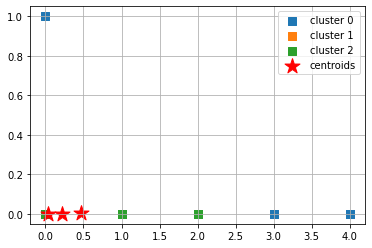

In [205]:
plot_clusters(np.array(venue_clustering), y_km, plt_cluster_centers= True)

# Resturant Data

In [206]:
# Import venue data within 1km of each neighborhood
restaurant_data = pd.read_csv('/Users/karina/GitHub/NYC_midterm_project/data/data/yelp_restaurant_type_counts_1km.csv')
restaurant_data.columns.values[0] = "id"
restaurant_data.head()

,id,caribbean,cocktailbars,seafood,spanish,chinese,breakfast_brunch,japanese,thai,wraps,...,pharmacy,farmersmarket,foodtours,bowling,syrian,southafrican,eventservices,bookstores,homedecor,diyfood
0,nyu_2451_34572.1,17.0,1.0,3.0,1.0,4.0,3.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,nyu_2451_34572.2,5.0,0.0,4.0,0.0,4.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,nyu_2451_34572.3,7.0,0.0,5.0,0.0,1.0,4.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,nyu_2451_34572.4,0.0,0.0,0.0,0.0,2.0,1.0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,nyu_2451_34572.5,0.0,2.0,2.0,0.0,3.0,1.0,3.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [207]:
# Create new dataframe for most common venues
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['id']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
restaurant_sorted = pd.DataFrame(columns=columns)
restaurant_sorted['id'] = restaurant_data['id']

for ind in np.arange(restaurant_data.shape[0]):
    restaurant_sorted.iloc[ind, 1:] = return_most_common_venues(restaurant_data.iloc[ind, :], num_top_venues)

restaurant_sorted.head()

,id,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,nyu_2451_34572.1,caribbean,pizza,sandwiches,burgers,chinese
1,nyu_2451_34572.2,hotdogs,pizza,caribbean,seafood,chicken_wings
2,nyu_2451_34572.3,caribbean,hotdogs,burgers,seafood,pizza
3,nyu_2451_34572.4,bars,delis,tradamerican,mexican,pizza
4,nyu_2451_34572.5,sandwiches,delis,pizza,burgers,bars


In [208]:
# Numeric Data for clustering
restaurant_clustering = restaurant_data.drop('id', axis=1)

### K-Means

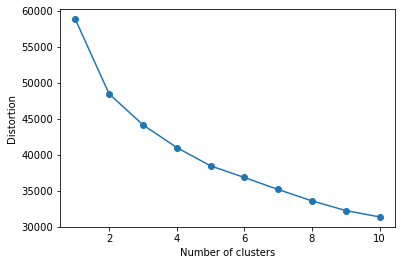

In [209]:
# Plot elbow graph
plot_distortion(restaurant_clustering)

In [210]:
# Cluster data points using kmeans and get labels
kclusters_resturant = 2

kmeans_restaurant = KMeans(n_clusters=kclusters_resturant, random_state=0).fit(restaurant_clustering)

kmeans_restaurant.labels_[0:10] 

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [211]:
y_km_restaurants = kmeans_restaurant.fit_predict(restaurant_clustering)

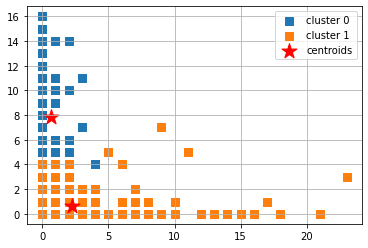

In [212]:
plot_clusters(np.array(restaurant_clustering), y_km_restaurants, plt_cluster_centers= True)

In [213]:
# Add cluster labels to venue data
restaurant_sorted.insert(0, 'clusters', kmeans.labels_)
clusters_resturant = restaurant_sorted.clusters.tolist()
restaurant_sorted = restaurant_sorted.drop('clusters', axis=1)

# Merge venue data with neighborhood data
all_restaurant_data = neighborhood_data.copy()
all_restaurant_data = pd.merge(all_restaurant_data, restaurant_sorted, on='id')
all_restaurant_data['clusters'] = clusters
all_restaurant_data = all_restaurant_data.drop('id', axis=1)

all_restaurant_data.head()

,borough,neighborhood,longitude,latitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,clusters
0,Bronx,Wakefield,-73.847201,40.894705,caribbean,pizza,sandwiches,burgers,chinese,0
1,Bronx,Co-op City,-73.829939,40.874294,hotdogs,pizza,caribbean,seafood,chicken_wings,0
2,Bronx,Eastchester,-73.827806,40.887556,caribbean,hotdogs,burgers,seafood,pizza,2
3,Bronx,Fieldston,-73.905643,40.895437,bars,delis,tradamerican,mexican,pizza,0
4,Bronx,Riverdale,-73.912585,40.890834,sandwiches,delis,pizza,burgers,bars,0


### Mapping

In [214]:
# Plot clusters on map of New York
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters_resturant)
ys = [i + x + (i*x)**2 for i in range(kclusters_resturant)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(all_restaurant_data['latitude'], all_restaurant_data['longitude'], all_restaurant_data['neighborhood'],all_restaurant_data['clusters']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [215]:
cluster0_restaurant = all_restaurant_data.loc[all_restaurant_data['clusters'] == 0, all_restaurant_data.columns[[0] + [1] + list(range(4, all_restaurant_data.shape[1]))]]
cluster1_restaurant = all_restaurant_data.loc[all_restaurant_data['clusters'] == 1, all_restaurant_data.columns[[0] + [1] + list(range(4, all_restaurant_data.shape[1]))]]

In [216]:
cluster0_restaurant

,borough,neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,clusters
0,Bronx,Wakefield,caribbean,pizza,sandwiches,burgers,chinese,0
1,Bronx,Co-op City,hotdogs,pizza,caribbean,seafood,chicken_wings,0
3,Bronx,Fieldston,bars,delis,tradamerican,mexican,pizza,0
4,Bronx,Riverdale,sandwiches,delis,pizza,burgers,bars,0
6,Manhattan,Marble Hill,mexican,latin,dominican,burgers,spanish,0
...,...,...,...,...,...,...,...,...
298,Bronx,Allerton,pizza,caribbean,mexican,tradamerican,seafood,0
299,Bronx,Kingsbridge Heights,mexican,latin,chinese,tradamerican,spanish,0
300,Brooklyn,Erasmus,caribbean,seafood,cafes,bakeries,cocktailbars,0
303,Queens,Bayswater,pizza,coffee,hotdogs,burgers,diners,0


In [217]:
print('--cluster0--')
print()
print('Top 5 most common venue type')
print(cluster0_restaurant['1st Most Common Venue'].value_counts()[:5])
print()
print('Top 5 second most common venue type')
print(cluster0_restaurant['2nd Most Common Venue'].value_counts()[:5])
print()
print('Most common borough')
print(cluster0_restaurant['borough'].value_counts()[:3])

--cluster0--

Top 5 most common venue type
pizza        31
italian      31
chinese      22
mexican      19
caribbean    18
Name: 1st Most Common Venue, dtype: int64

Top 5 second most common venue type
pizza               36
chinese             22
italian             17
breakfast_brunch    16
cocktailbars        15
Name: 2nd Most Common Venue, dtype: int64

Most common borough
Queens           62
Brooklyn         53
Staten Island    43
Name: borough, dtype: int64


In [218]:
print('--cluster0--')
print()
print('Top 5 most common venue type')
print(cluster1_restaurant['1st Most Common Venue'].value_counts()[:5])
print()
print('Top 5 second most common venue type')
print(cluster1_restaurant['2nd Most Common Venue'].value_counts()[:5])
print()
print('Most common borough')
print(cluster1_restaurant['borough'].value_counts()[:3])

--cluster0--

Top 5 most common venue type
italian      7
pizza        4
caribbean    3
mexican      2
chinese      2
Name: 1st Most Common Venue, dtype: int64

Top 5 second most common venue type
pizza        6
chinese      4
delis        4
sushi        2
caribbean    2
Name: 2nd Most Common Venue, dtype: int64

Most common borough
Queens           11
Staten Island     7
Brooklyn          6
Name: borough, dtype: int64


# All Features - Not Scaled

In [219]:
neighborhood_id = pd.read_csv('/Users/karina/GitHub/NYC_midterm_project/data/old_dataset.csv')
neighborhood_id = pd.DataFrame(neighborhood_id['id'])
neighborhood_id.head()

,id
0,nyu_2451_34572.1
1,nyu_2451_34572.2
2,nyu_2451_34572.3
3,nyu_2451_34572.4
4,nyu_2451_34572.5


In [228]:
# Import venue data within 1km of each neighborhood
features_data = pd.read_csv('/Users/karina/GitHub/NYC_midterm_project/data/data/all_features_counts.csv')
features_data = features_data.iloc[:, 2:]
features_data = pd.concat([neighborhood_id, features_data], axis=1)
features_data.head()


,id,accounting,amusement_park,aquarium,art_gallery,bakery,bank,bar,beauty_salon,bicycle_store,...,pharmacy.1,farmersmarket,foodtours,bowling,syrian,southafrican,eventservices,bookstores,homedecor,diyfood
0,nyu_2451_34572.1,1,0,0,0,1,2,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,nyu_2451_34572.2,0,0,0,0,1,1,0,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,nyu_2451_34572.3,0,0,0,0,1,0,4,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,nyu_2451_34572.4,0,0,0,1,2,0,4,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,nyu_2451_34572.5,0,0,0,0,0,2,5,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [229]:
# Create new dataframe for most common venues
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['id']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
features_sorted = pd.DataFrame(columns=columns)
features_sorted['id'] = features_data['id']

for ind in np.arange(restaurant_data.shape[0]):
    features_sorted.iloc[ind, 1:] = return_most_common_venues(features_data.iloc[ind, :], num_top_venues)

features_sorted.head()

,id,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,nyu_2451_34572.1,caribbean,pizza,school,burgers,sandwiches
1,nyu_2451_34572.2,hotdogs,pizza,secondary_school,church,caribbean
2,nyu_2451_34572.3,doctor,caribbean,hotdogs,burgers,seafood
3,nyu_2451_34572.4,lodging,cafe,bars,night_club,delis
4,nyu_2451_34572.5,restaurant,sandwiches,burgers,pizza,delis


In [230]:
# Drop neighborhood ID to create numerical data for k-means clustering
features_clustering = features_data.drop('id', axis=1)

### K-Means

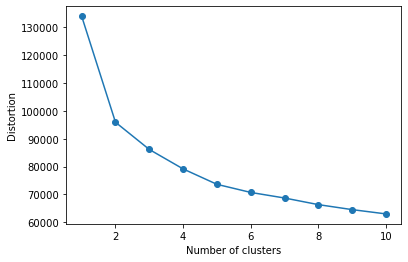

In [231]:
# Plot elbow graph
plot_distortion(features_clustering)

In [232]:
# Cluster data points using kmeans and get labels
kclusters_features = 2

kmeans_features = KMeans(n_clusters=kclusters_features, random_state=0).fit(features_clustering)

kmeans_features.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

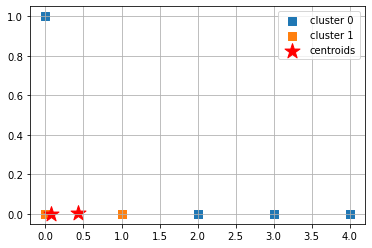

In [233]:
y_km_features = kmeans_features.fit_predict(features_clustering)
plot_clusters(np.array(features_clustering), y_km_features, plt_cluster_centers= True)

In [ ]:
# Add cluster labels to venue data
features_sorted.insert(0, 'clusters', kmeans.labels_)
clusters_features = restaurant_sorted.clusters.tolist()
restaurant_sorted = restaurant_sorted.drop('clusters', axis=1)

# Merge venue data with neighborhood data
all_restaurant_data = neighborhood_data.copy()
all_restaurant_data = pd.merge(all_restaurant_data, restaurant_sorted, on='id')
all_restaurant_data['clusters'] = clusters
all_restaurant_data = all_restaurant_data.drop('id', axis=1)

all_restaurant_data.head()

### Mapping

# All Features - Scaled by Population

In [222]:
# Import venue data within 1km of each neighborhood
features_scaled_data = pd.read_csv('/Users/karina/GitHub/NYC_midterm_project/data/data/all_features_scaled.csv')
features_scaled_data.head()

,accounting,amusement_park,aquarium,art_gallery,bakery,bank,bar,beauty_salon,bicycle_store,book_store,...,pharmacy.1,farmersmarket,foodtours,bowling,syrian,southafrican,eventservices,bookstores,homedecor,diyfood
0,0.870296,-0.05726,-0.05726,-0.304725,0.524484,1.465681,-0.476286,-0.493993,-0.212622,-0.32431,...,-0.05726,-0.05726,-0.099504,-0.099504,-0.081111,-0.05726,-0.05726,-0.099504,-0.099504,-0.05726
1,-0.546249,-0.05726,-0.05726,-0.304725,0.524484,0.374444,-0.476286,2.590942,-0.212622,-0.32431,...,-0.05726,-0.05726,-0.099504,-0.099504,-0.081111,-0.05726,-0.05726,-0.099504,-0.099504,-0.05726
2,-0.546249,-0.05726,-0.05726,-0.304725,0.524484,-0.716793,0.774732,1.048474,-0.212622,-0.32431,...,-0.05726,-0.05726,-0.099504,-0.099504,-0.081111,-0.05726,-0.05726,-0.099504,-0.099504,-0.05726
3,-0.546249,-0.05726,-0.05726,3.281651,1.759037,-0.716793,0.774732,-0.493993,-0.212622,-0.32431,...,-0.05726,-0.05726,-0.099504,-0.099504,-0.081111,-0.05726,-0.05726,-0.099504,-0.099504,-0.05726
4,-0.546249,-0.05726,-0.05726,-0.304725,-0.710070,1.465681,1.087487,-0.493993,-0.212622,-0.32431,...,-0.05726,-0.05726,-0.099504,-0.099504,-0.081111,-0.05726,-0.05726,-0.099504,-0.099504,-0.05726


In [ ]:
# Numeric Data for clustering
features_scaled_clustering = features_scaled_data.drop('id', axis=1)

### K-Means

### Mapping